In [3]:
import kagglehub


/home/igor-czudy/miniconda3/envs/color_img/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [4]:
# sautkin/imagenet1k1 sautkin/imagenet1k2 sautkin/imagenet1k3 sautkin/imagenet1kvalid

path = kagglehub.dataset_download("sautkin/imagenet1k0")

print("Path to dataset files:", path)

100%|██████████| 11.9G/11.9G [53:02<00:00, 4.01MB/s]  

Extracting files...


Path to dataset files: /home/igor-czudy/.cache/kagglehub/datasets/sautkin/imagenet1k0/versions/2


In [7]:
!cp -r /home/igor-czudy/.cache/kagglehub/datasets/sautkin/imagenet1k0/versions/2 .

In [11]:
import tensorflow as tf


In [12]:
import cv2

In [42]:
image = cv2.imread('2/00000/01442807324571.jpg') #BGR format

In [43]:
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB) #RGB format

In [44]:
image.shape

(299, 450, 3)

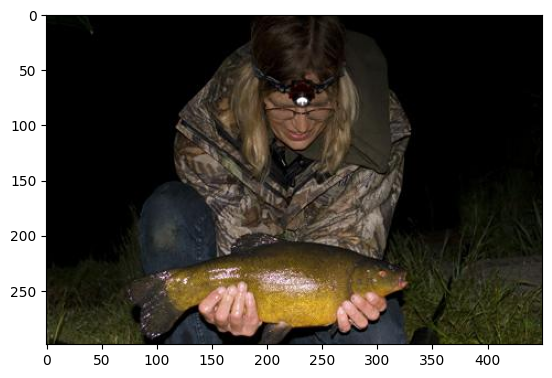

In [45]:
import matplotlib.pyplot as plt

plt.imshow(image)

In [46]:
# image = cv2.resize(image, (450, 298)) 

# plt.imshow(image)

In [47]:
image_grey = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY) #RGB format

In [48]:
image_grey.shape

(299, 450)

In [49]:
image_grey

array([[12, 11, 11, ...,  0,  0,  0],
       [11, 11, 10, ...,  0,  0,  0],
       [12, 12, 12, ...,  0,  0,  0],
       ...,
       [77, 56, 65, ..., 65, 47, 52],
       [76, 52, 67, ..., 61, 43, 49],
       [74, 46, 72, ..., 40, 42, 48]], dtype=uint8)

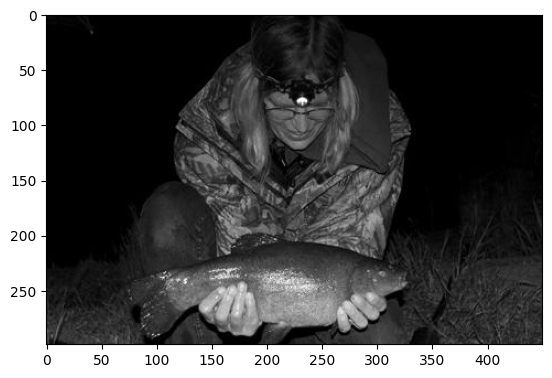

In [50]:
plt.imshow(image_grey, cmap='grey')

In [51]:
from tensorflow.keras.layers import Conv2D




In [52]:
conv = Conv2D(filters=64, kernel_size=(5,5), strides=(2, 2), padding="same")

In [53]:
import numpy as np 

print(image_grey.shape)
image_grey = image_grey[..., np.newaxis]
print(image_grey.shape) # (height, width, channels)

# convolutional layers expect a 3D tensor for a single image with the shape (height, width, channels) — where:
# channels represents the number of color channels (for grayscale, it's 1, and for RGB, it's 3).
# 1 represents the 1 channel for grayscale.

(299, 450)
(299, 450, 1)


In [54]:
image_grey = image_grey[np.newaxis, ...] #(batch_size, height, width, channels)

In [55]:
image = image[np.newaxis, ...]

In [56]:
image_grey = image_grey / 255

In [57]:
image = image / 255

In [13]:
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dropout, BatchNormalization, Conv2D, Conv2DTranspose
from tensorflow.keras.optimizers import Adam, AdamW

class Encoder(Model):
    def __init__(self, filters, kernel_size):
        super().__init__()

        self.my_layers = []
        for filter in filters:
            self.my_layers.append(
                Conv2D(filters=filter, kernel_size=kernel_size, strides=(2,2), padding="same", activation='relu')
            )
            
    def call(self, inputs, training=False):
        for my_layer in self.my_layers:
            inputs = my_layer(inputs)

        return inputs
    
class Decoder(Model):
    def __init__(self, filters, kernel_size):
        super().__init__()

        self.my_layers = []
        for filter in filters:
            self.my_layers.append(
                Conv2DTranspose(filters=filter, kernel_size=kernel_size, strides=2, padding="same", activation='relu')
            )
        self.my_layers.append(
            Conv2D(filters=3, kernel_size=(3, 3), strides=1, padding="same", activation='sigmoid')
        )

    
    def call(self, inputs, training=False):
        for my_layer in self.my_layers:
            inputs = my_layer(inputs)        
        return inputs
    

class Autoencoder(Model):
    def __init__(self, filters, kernel_size):
        super().__init__()
        self.encoder = Encoder(filters=filters, kernel_size=kernel_size)
        self.decoder = Decoder(filters=filters[::-1], kernel_size=kernel_size) # orginal_img_size=orginal_img_size

    def call(self, inputs, training=False):
        orginal_img_size = inputs.shape[1:-1]
        inputs = self.encoder(inputs)
        inputs = self.decoder(inputs)
        inputs = tf.image.resize(inputs, orginal_img_size)
        return inputs


print(image_grey.shape)
# encoder = Encoder(filters=[16, 32, 64, 128], kernel_size=(3, 3))
# decoder = Decoder(filters=[128, 64, 32, 16], kernel_size=(3, 3))
# inputs = image_grey
# orginal_img_size = inputs.shape[1:-1]
# out = encoder(inputs)
# out = decoder(out)
# inputs = tf.image.resize(out, orginal_img_size)
# print(inputs.shape)

autoencoder= Autoencoder(filters=[128, 64, 32, 16], kernel_size=(3, 3))
autoencoder(image_grey).shape


NameError: name 'image_grey' is not defined

In [59]:
optimizer = AdamW()
model = Autoencoder(filters=[128, 64, 32, 16], kernel_size=(3, 3))
model.compile(optimizer=optimizer, loss='mse', metrics=['accuracy'])
model.fit(image_grey, image, epochs=30)

Epoch 1/30
1/1 ━━━━━━━━━━━━━━━━━━━━ 5s 5s/step - accuracy: 0.2731 - loss: 0.1633
Epoch 2/30
1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step - accuracy: 0.1480 - loss: 0.1623
Epoch 3/30
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step - accuracy: 0.1480 - loss: 0.1610
Epoch 4/30
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step - accuracy: 0.1480 - loss: 0.1594
Epoch 5/30
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step - accuracy: 0.1481 - loss: 0.1573
Epoch 6/30
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step - accuracy: 0.1481 - loss: 0.1548
Epoch 7/30
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step - accuracy: 0.1481 - loss: 0.1518
Epoch 8/30
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step - accuracy: 0.1480 - loss: 0.1481
Epoch 9/30
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step - accuracy: 0.1480 - loss: 0.1436
Epoch 10/30
1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step - accuracy: 0.1479 - loss: 0.1381
Epoch 11/30
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step - accuracy: 0.1476 - loss: 0.1312
Epoch 12/30
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step - accuracy: 0.1474 - loss: 0.1226
Epoch 13/30
1/1 ━━━━━━━━━

In [169]:
print(image_grey.shape)
conv = Conv2D(filters=16, kernel_size=(3, 3), strides=2, padding="same", activation='relu')
input = conv(image_grey)
print(input.shape)

conv = Conv2D(filters=32, kernel_size=(3, 3), strides=2, padding="same", activation='relu')
input = conv(input)
print(input.shape)

conv = Conv2D(filters=64, kernel_size=(3, 3), strides=2, padding="same", activation='relu')
input = conv(input)
print(input.shape)

conv = Conv2D(filters=128, kernel_size=(3, 3), strides=2, padding="same", activation='relu')
input = conv(input)
print(input.shape)

(1, 298, 450, 1)
(1, 149, 225, 16)
(1, 75, 113, 32)
(1, 38, 57, 64)
(1, 19, 29, 128)


In [170]:
print(input.shape)
conv = Conv2DTranspose(filters=128, kernel_size=(3, 3), strides=2, padding="same", activation='relu')
input = conv(input)
print(input.shape)

conv = Conv2DTranspose(filters=64, kernel_size=(3, 3), strides=2, padding="same", activation='relu')
input = conv(input)
print(input.shape)

conv = Conv2DTranspose(filters=32, kernel_size=(3, 3), strides=2, padding="same", activation='relu')
input = conv(input)
print(input.shape)

conv = Conv2DTranspose(filters=16, kernel_size=(3, 3), strides=2, padding="same", activation='relu')
input = conv(input)
print(input.shape)

conv = Conv2D(filters=3, kernel_size=(3, 3), strides=1, padding = "same", activation='sigmoid')
input = conv(input)
print(input.shape)

reshape = tf.image.resize(input, image_grey.shape[1:-1])
print(reshape.shape)



(1, 19, 29, 128)
(1, 38, 58, 128)
(1, 76, 116, 64)
(1, 152, 232, 32)
(1, 304, 464, 16)
(1, 304, 464, 3)
(1, 298, 450, 3)


In [78]:
import os 

class DataSetGenerator(Sequence):
    def __init__(self, batch_size, root_file):
        

        self.batch_size = batch_size
        self.root_file = root_file
        self.list_of_img_paths = self.get_list_of_files()
        self.indexes = np.arange(len(self.list_of_img_paths))


    def get_list_of_files(self):
        img_path = []
        for root, _, files in os.walk(self.root_file):
            for file in files:
                img_path.append(os.path.join(root, file))
        return img_path[:40]


    def __len__(self):
        return len(self.list_of_img_paths) // self.batch_size


    def __getitem__(self, idx):
        image_path = self.list_of_img_paths[idx]

        image = cv2.imread(image_path) #BGR format
        image_grey = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY) #RGB format
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB) #RGB format

        image_grey = cv2.resize(image_grey, (300, 450))
        image = cv2.resize(image, (300, 450))

        image_grey = image_grey / 255.0
        image = image / 255.0

        image_grey_tensor = tf.convert_to_tensor(image_grey, dtype=tf.float32)
        image = tf.convert_to_tensor(image, dtype=tf.float32)

        image_grey_tensor = tf.expand_dims(image_grey_tensor, axis=-1)  # (H, W, 1)
        x = tf.expand_dims(image_grey_tensor, axis=0)
        y = tf.expand_dims(image, axis=0)
        
        return x, y

    

dataSetGenerator = DataSetGenerator(batch_size=16, root_file="2")

In [79]:
optimizer = AdamW()
model = Autoencoder(filters=[128, 64, 32, 16], kernel_size=(3, 3))
model.compile(optimizer=optimizer, loss='mse', metrics=['accuracy'])

model.fit(dataSetGenerator, epochs=30)


Epoch 1/30
2/2 ━━━━━━━━━━━━━━━━━━━━ 9s 3s/step - accuracy: 0.5024 - loss: 0.1063
Epoch 2/30
2/2 ━━━━━━━━━━━━━━━━━━━━ 7s 3s/step - accuracy: 0.8632 - loss: 0.0838
Epoch 3/30
2/2 ━━━━━━━━━━━━━━━━━━━━ 7s 3s/step - accuracy: 0.8632 - loss: 0.0834
Epoch 4/30
2/2 ━━━━━━━━━━━━━━━━━━━━ 7s 3s/step - accuracy: 0.7793 - loss: 0.1049
Epoch 5/30
2/2 ━━━━━━━━━━━━━━━━━━━━ 7s 3s/step - accuracy: 0.8632 - loss: 0.0805
Epoch 6/30
2/2 ━━━━━━━━━━━━━━━━━━━━ 7s 3s/step - accuracy: 0.8632 - loss: 0.0764
Epoch 7/30
2/2 ━━━━━━━━━━━━━━━━━━━━ 7s 3s/step - accuracy: 0.8632 - loss: 0.0714
Epoch 8/30
2/2 ━━━━━━━━━━━━━━━━━━━━ 7s 3s/step - accuracy: 0.7793 - loss: 0.0879
Epoch 9/30
2/2 ━━━━━━━━━━━━━━━━━━━━ 7s 3s/step - accuracy: 0.8632 - loss: 0.0776
Epoch 10/30
2/2 ━━━━━━━━━━━━━━━━━━━━ 7s 3s/step - accuracy: 0.7793 - loss: 0.0786
Epoch 11/30
2/2 ━━━━━━━━━━━━━━━━━━━━ 7s 3s/step - accuracy: 0.7793 - loss: 0.0794
Epoch 12/30
2/2 ━━━━━━━━━━━━━━━━━━━━ 7s 3s/step - accuracy: 0.8632 - loss: 0.0678
Epoch 13/30
2/2 ━━━━━━━━━